# Lab 2
This is the 500-hPa jupyter notebook for lab 2. First we will import some libraries and functions. 

In [12]:
import numpy as np
from netCDF4 import MFDataset 
from netCDF4 import Dataset 
import matplotlib
matplotlib.use('Agg')
import matplotlib.pylab as plt
from datetime import datetime
from netCDF4 import num2date
from netCDF4 import date2index
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from metpy.units import units
import xarray as xr
import cartopy.util as cutil
%matplotlib inline

Our next setep is to specify the netCDF files. 

In [18]:
ds = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/air.mon.mean.nc')
ds2 = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/hgt.mon.mean.nc')
ds3 = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/uwnd.mon.mean.nc')
ds4 = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/vwnd.mon.mean.nc')


Indicate the desired pressure level, year and month!

In [72]:
plevel = 200
obslvl = plevel
month = 1
monthlabel = 'January'

Now we extract the data desired. The ::12 is to take every 12th month, set about the month (tm) we selected. Be patient, since this step may take a minute! (The * indicates that the process is still working.) 

In [93]:
# Grab lat/lon values
lats = ds.lat.data
lons = ds.lon.data

#subtract 1 from tm because the first observation in Python is observation 0
tm = int(month)-1
temp = ds.air.sel(level=plevel)[tm::12,:,:]
hght = ds2.hgt.sel(level=plevel)[tm::12,:,:]
uwnd = np.asarray(ds3.uwnd.sel(level=plevel).values[:][tm::12,:,:] * units('m/s'))
vwnd = np.asarray(ds4.vwnd.sel(level=plevel).values[:][tm::12,:,:] * units('m/s'))
u_barbs = ds3.uwnd.sel(level=plevel).values[:][tm::12,:,:] * units('m/s')
v_barbs = ds4.vwnd.sel(level=plevel).values[:][tm::12,:,:] * units('m/s')

Print the numpy shapes of the temperature, latitude and longtitude. This can be important when debugging.

In [94]:
print (np.shape(temp))
print (np.shape(lats))
print (np.shape(lons))

(78, 73, 144)
(73,)
(144,)


Select the countour settings for the temperature (in degrees C) and SLP (in hPa). The format is (minimum, maximum, interval) 

In [103]:
clevs_temp = np.arange(-30,30,3)
clevs_hght = np.arange(0, 15000, 120)
#For lab 3:
#clevs_uwnd = ?
#clevs_vwind = ?


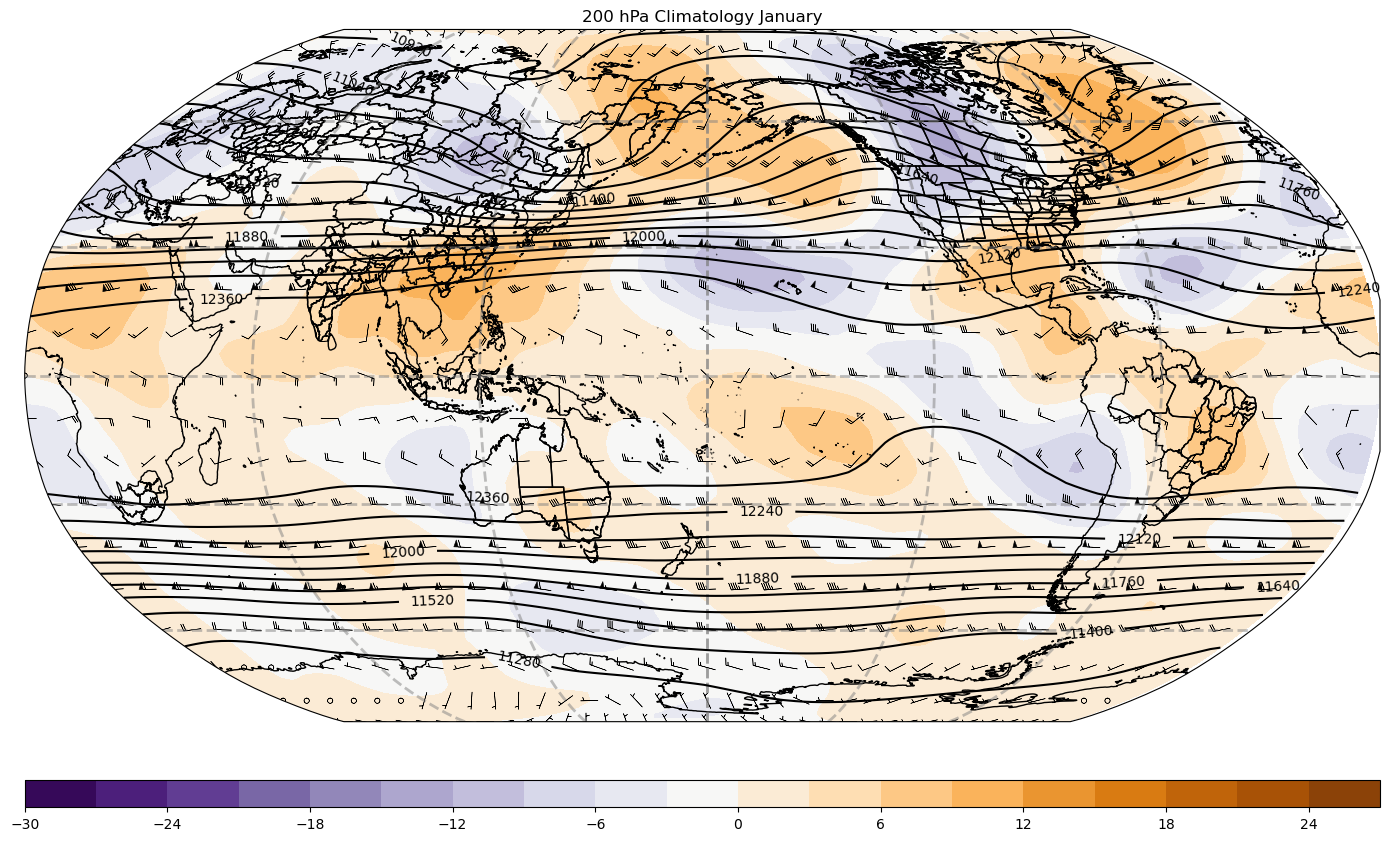

In [104]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.Robinson(central_longitude=180)

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)

#not needed here, but used for sub-setting domain to plot
#ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))
gl = ax.gridlines(color='gray',linewidth=2, alpha = 0.5, linestyle='--')

# labels gridlines for PlateCarree ccrs option (doesn't work with Robinson, etc.)
#gl.xlabels_top = False
#gl.ylabels_right = False

#color-filled contour time!
#plotting temperature and including color bar
cf = ax.contourf(lons, lats, np.mean(vwnd[:,:,:],axis=0), clevs_temp, cmap=plt.cm.PuOr_r, transform=datacrs)
plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)

# Plot 500-hPa Geopotential Heights in meters
cs = ax.contour(lons, lats, np.mean(hght[:,:,:],axis=0), clevs_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
ax.barbs(lons[::4], lats[::4], np.mean(u_barbs.to('kt')[:,::4,::4].m,axis=0), 
         np.mean(v_barbs.to('kt')[:,::4,::4].m, axis=0), pivot='middle',
         color='black', transform=datacrs, length=5, linewidth=0.4)

# Make some nice titles for the plot (one right, one left)
plt.title(f'{obslvl} hPa Climatology ' + str(monthlabel))

# Reduce excessive white space around image and show
plt.tight_layout()
plt.savefig(f'{obslvl}hPaClimatology' + str(monthlabel), dpi=150)
plt.show()

Now we will make a map of the standard deviation of sea level pressure (SLP) for our selected month. We could do this in a separate notebook, but placing it here saves us from re-reading in the data.  

We need to set levels for the standard deviation, since the scale is much different!

In [87]:
levels_sd = np.arange(0,11.1,1)

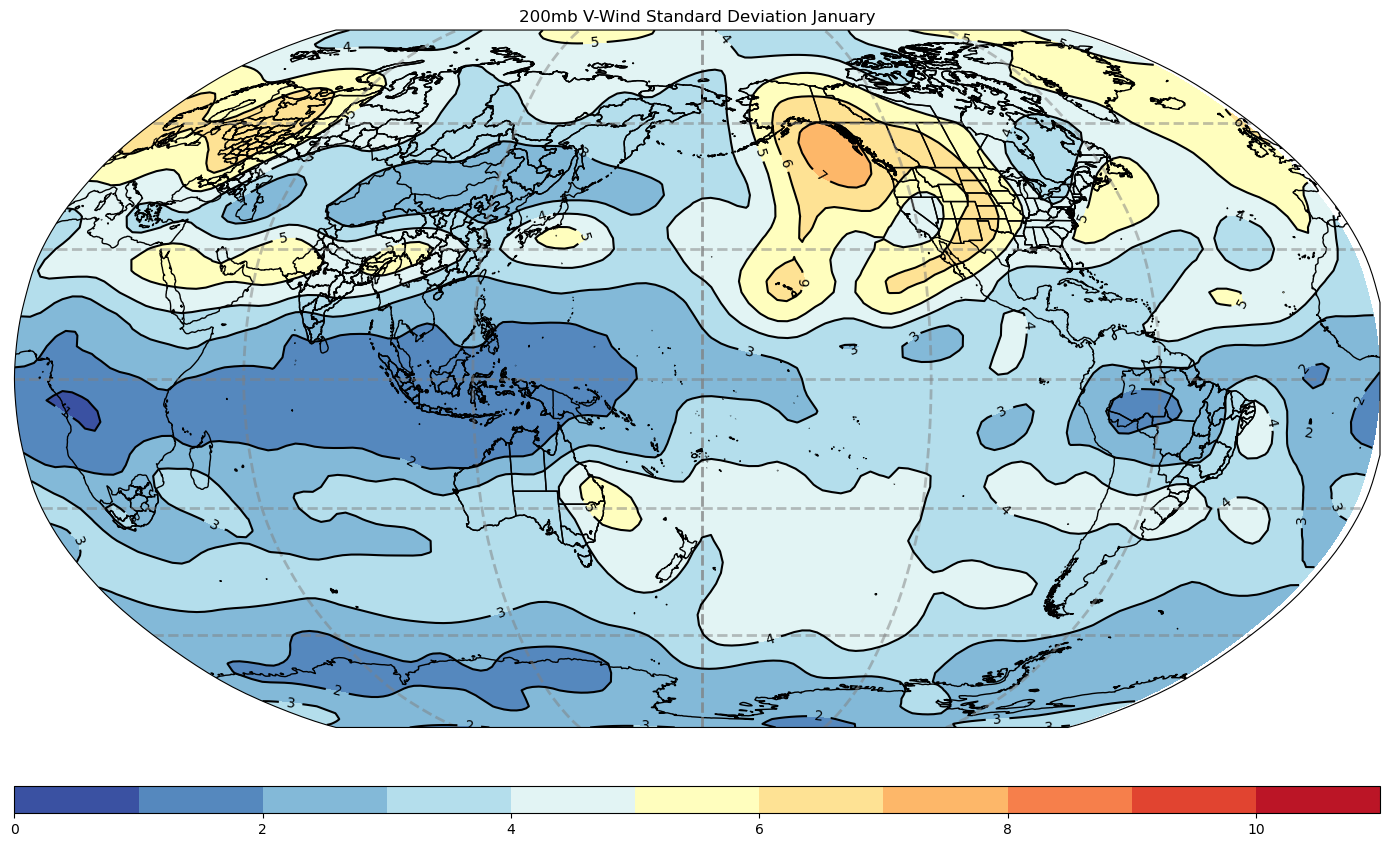

In [106]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.Robinson(central_longitude=180)

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(2, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))
gl = ax.gridlines(color='gray',linewidth=2, alpha = 0.5, linestyle='--')

# labels gridlines for PlateCarree ccrs option (doesn't work with Robinson, etc.)
#gl.xlabels_top = False
#gl.ylabels_right = False

#color-filled contour time!
#plotting temperature and including color bar
cf = ax.contourf(lons, lats, np.std(vwnd[:,:,:],axis=0), levels_sd, cmap=plt.cm.RdYlBu_r, transform=datacrs)
plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)

# Plot 500-hPa Geopotential Heights in meters
cs = ax.contour(lons, lats, np.std(vwnd[:,:,:],axis=0), levels_sd, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

# Make some nice titles for the plot (one right, one left)
plt.title(f'{obslvl}mb V-Wind Standard Deviation ' + str(monthlabel))

# Reduce excessive white space around image and show
plt.tight_layout()
plt.savefig(f'{obslvl}vwndstandarddeviation' + str(monthlabel), dpi=150)
plt.show()